# Better cats and dogs binary classification

Dataset source: [Kaggle: Cat VS Dog Dataset](https://www.kaggle.com/datasets/karakaggle/kaggle-cat-vs-dog-dataset/data) 

## Python imports

In [1]:
# Base Python
import os
import time
import random
import warnings

# Data processing and modelization
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix  # Avoid duplicate imports
import kagglehub

# Monitoring and visualization
from PIL import Image
from utils import plot_confusion_matrix, plot_training_metrics, show_random_samples, get_random_samples, plot_score_distribution, plot_sensitivity_specificity_vs_thresholds, plot_roc_curve 

# Model export and loading
import onnx
import onnxruntime as ort

/home/malo/miniconda3/envs/faced/lib/python3.12/site-packages/onnxscript/converter.py:820: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/home/malo/miniconda3/envs/faced/lib/python3.12/site-packages/onnxscript/converter.py:820: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/home/malo/miniconda3/envs/faced/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Software versions
```
- Python v3.12.5
```
### Packages

```
- numpy v1.26.4
- cuda v12.1
- torch v2.4.1+cu121
- torchvision v0.19.1+cu121
- onnx v1.16.2
- sklearn v1.5.2
- onnxruntime v1.20.0
```

## Python setup

In [2]:
warnings.filterwarnings('ignore')

## GPU selection

In [3]:
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    device = 'cuda'
    torch.cuda.get_device_name(0)
    torch.set_default_device(device)
    print(f'CUDA is available. Training on {torch.cuda.get_device_name()}')
else:
    device = 'cpu'
    print('CUDA is not available. Training on CPU')
generator = torch.Generator(device=device)

CUDA is available. Training on NVIDIA GeForce RTX 4070


## Condition reproducibility

Source: [Pytorch](https://pytorch.org/docs/stable/notes/randomness.html)

In [4]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
# Set the environment variable for deterministic behavior
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"  # or ":16:8"

if train_on_gpu:
    torch.cuda.manual_seed_all(SEED)

## Dataset download

In [5]:
path = kagglehub.dataset_download("karakaggle/kaggle-cat-vs-dog-dataset")
dogs_path = os.path.join(path, "kagglecatsanddogs_3367a/PetImages/Dog")
cats_path = os.path.join(path, "kagglecatsanddogs_3367a/PetImages/Cat")
path

'/home/malo/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1'

## Dataset checking

In [6]:
from PIL import Image
import os

def remove_corrupted_images(directory):
    initial_count = len([name for name in os.listdir(directory) if name.endswith('.jpg')])
    corrupted_files = []
    
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        
        try:
            # Open the image to check its validity
            with Image.open(file_path) as img:
                img.verify()  # Verify if the image can be opened
        except (IOError, SyntaxError):
            print(f"Corrupted file detected and removed: {file_path}")
            corrupted_files.append(file_path)
            os.remove(file_path)  # Remove the corrupted file

    remaining_count = initial_count - len(corrupted_files)
    print(f"Total images in {directory}: {remaining_count} (after removing {len(corrupted_files)} corrupted files)")

# Use the function on each folder
remove_corrupted_images(dogs_path)
remove_corrupted_images(cats_path)

Total images in /home/malo/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Dog: 12469 (after removing 0 corrupted files)
Total images in /home/malo/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Cat: 12490 (after removing 0 corrupted files)


## Dataset volume selection

## Pytorch Dataset initialization 

### Images transformation

In [7]:
# Define data augmentation transformations
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.ToTensor(),             # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize (for grayscale images)
])

data_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [8]:
# Paramètres
TOTAL_SAMPLES = 16000
TRAIN_SIZE = 0.85  # 70% des images pour l'entraînement
VAL_SIZE = 0.05   # 15% pour la validation
TEST_SIZE = 0.10  # 15% pour le test
BATCH_SIZE = 256

# Calculate the number of samples for each class
dog_samples = TOTAL_SAMPLES // 2
cat_samples = TOTAL_SAMPLES // 2

# Get the required number of samples for each class
dog_images = [os.path.join(dogs_path, img) for img in os.listdir(dogs_path) if img.endswith(".jpg")][:dog_samples]
cat_images = [os.path.join(cats_path, img) for img in os.listdir(cats_path) if img.endswith(".jpg")][:cat_samples]

# Associer les images avec leurs labels
all_images = dog_images + cat_images
all_labels = [0] * len(dog_images) + [1] * len(cat_images)

# Diviser en trois sous-ensembles (train, val, test)
train_imgs, temp_imgs, train_labels, temp_labels = train_test_split(
    all_images, all_labels, test_size=(1 - TRAIN_SIZE), stratify=all_labels, random_state=42
)
val_imgs, test_imgs, val_labels, test_labels = train_test_split(
    temp_imgs, temp_labels, test_size=(TEST_SIZE / (VAL_SIZE + TEST_SIZE)), stratify=temp_labels, random_state=42
)

# Dataset personnalisé pour gérer les images et leurs labels
class CatDogDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

# Création des datasets avec les transformations correspondantes
train_dataset = CatDogDataset(train_imgs, train_labels, transform=train_transforms)
val_dataset = CatDogDataset(val_imgs, val_labels, transform=data_transform)
test_dataset = CatDogDataset(test_imgs, test_labels, transform=data_transform)

# Création des DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=generator, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, generator=generator)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, generator=generator)

train_samples = len(train_loader.dataset)
val_samples = len(val_loader.dataset)
test_samples = len(test_loader.dataset)

print(f"Number of training samples: {train_samples}")
print(f"Number of validation samples: {val_samples}")
print(f"Number of test samples: {test_samples}")

Number of training samples: 13599
Number of validation samples: 800
Number of test samples: 1601


## Sample displaying

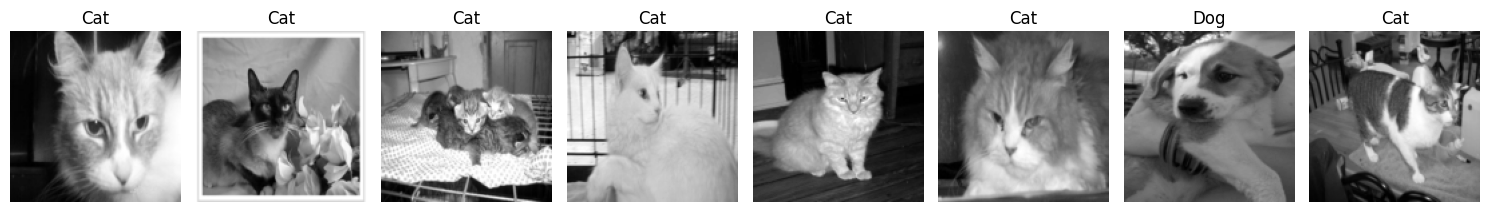

In [9]:
classes = ["Dog", "Cat"]
show_random_samples(train_dataset, classes)

## Model definition

In [10]:
class CNNBinaryClassifier(nn.Module):
    def __init__(self, input_shape=(1, 128, 128)):
        super(CNNBinaryClassifier, self).__init__()
        
        # Couches de convolution
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bnorm1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bnorm2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bnorm3 = nn.BatchNorm2d(128)
        
        # Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Déterminer la taille d'entrée de la couche FC
        self.flattened_size = self._get_flattened_size(input_shape)
        
        # Couches entièrement connectées
        self.fc1 = nn.Linear(self.flattened_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 1)
        
        # Dropout
        self.dropout = nn.Dropout(0.4)
    
    def _get_flattened_size(self, input_shape):
        x = torch.zeros(1, *input_shape)
        x = self.pool(F.relu(self.bnorm1(self.conv1(x))))
        x = self.pool(F.relu(self.bnorm2(self.conv2(x))))
        x = self.pool(F.relu(self.bnorm3(self.conv3(x))))
        return int(np.prod(x.size()))

    def forward(self, x):
        x = self.pool(F.relu(self.bnorm1(self.conv1(x))))
        x = self.pool(F.relu(self.bnorm2(self.conv2(x))))
        x = self.pool(F.relu(self.bnorm3(self.conv3(x))))
        
        x = x.view(-1, self.flattened_size)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc4(x))
        
        return x

## Validation code

In [11]:
def validate_model(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:

            train_on_gpu = torch.cuda.is_available()
            
            if train_on_gpu:
                images = images.cuda()
                labels = labels.cuda()
                
            outputs = model(images)

            # Binary classification with sigmoid activation
            preds = (outputs > 0.5).float()# Convert probabilities to binary predictions

            all_preds.extend(preds.detach().cpu().numpy().flatten())
            all_labels.extend(labels.detach().cpu().numpy().flatten())

    # Convert predictions and labels to numpy arrays
    all_preds = np.array(all_preds).astype(int)  # Convert predictions
    all_labels = np.array(all_labels).astype(int)  # Convert labels

    # Ensure the lengths are consistent
    if len(all_preds) != len(all_labels):
        raise ValueError(f"Found input variables with inconsistent numbers of samples: [{len(all_preds)}, {len(all_labels)}]")


    accuracy = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    return accuracy, cm

## Training

In [12]:
def save_checkpoint(model, epoch, directory="./checkpoints"):
    # Créer le répertoire s'il n'existe pas
    os.makedirs(directory, exist_ok=True)
    
    # Sauvegarder le checkpoint
    filename = os.path.join(directory, f"{epoch}.pt")
    torch.save(model.state_dict(), filename)
    print(f"Checkpoint saved: {filename}")

def load_nearest_checkpoint(model, target_epoch, directory="./checkpoints"):
    # Vérifier si le répertoire existe et contient des fichiers
    if not os.path.exists(directory) or not os.listdir(directory):
        print("No checkpoints found. Starting from epoch 0.")
        return 0

    # Récupérer la liste des checkpoints disponibles (sous forme d'époques)
    available_epochs = []
    for file in os.listdir(directory):
        if file.endswith(".pt"):
            try:
                epoch = int(file.split(".")[0])
                available_epochs.append(epoch)
            except ValueError:
                pass
    
    # Vérifier si on a trouvé des checkpoints valides
    if not available_epochs:
        print("No checkpoints found. Starting from epoch 0.")
        return 0

    # Trouver l'époque la plus proche mais inférieure ou égale à target_epoch
    nearest_epoch = max((epoch for epoch in available_epochs if epoch <= target_epoch), default=None)
    
    if nearest_epoch is not None:
        # Charger le checkpoint le plus proche
        checkpoint_path = os.path.join(directory, f"{nearest_epoch}.pt")
        model.load_state_dict(torch.load(checkpoint_path))
        print(f"Checkpoint loaded: {checkpoint_path} (Epoch {nearest_epoch})")
        return nearest_epoch
    else:
        print("No suitable checkpoint found. Starting from epoch 0.")
        return 0

Epoch [1/10], Loss: 0.664604, Accuracy: 59.77%, Val accuracy: 65.12%, Epoch time: 27.52s
Epoch [2/10], Loss: 0.588233, Accuracy: 68.595%, Epoch time: 23.38s
Epoch [3/10], Loss: 0.512265, Accuracy: 74.455%, Epoch time: 24.06s
Epoch [4/10], Loss: 0.479761, Accuracy: 76.725%, Epoch time: 24.21s
Epoch [5/10], Loss: 0.446763, Accuracy: 78.95%, Val accuracy: 79.38%, Epoch time: 22.73s
Epoch [6/10], Loss: 0.406943, Accuracy: 81.692%, Epoch time: 24.70s
Epoch [7/10], Loss: 0.389844, Accuracy: 82.260%, Epoch time: 24.42s
Epoch [8/10], Loss: 0.388780, Accuracy: 82.400%, Epoch time: 25.29s
Epoch [9/10], Loss: 0.354821, Accuracy: 84.12%, Val accuracy: 79.50%, Epoch time: 24.20s
Epoch [10/10], Loss: 0.329437, Accuracy: 85.525%, Epoch time: 24.39s

Total training time: 248.33s
Average time per epoch: 24.49s


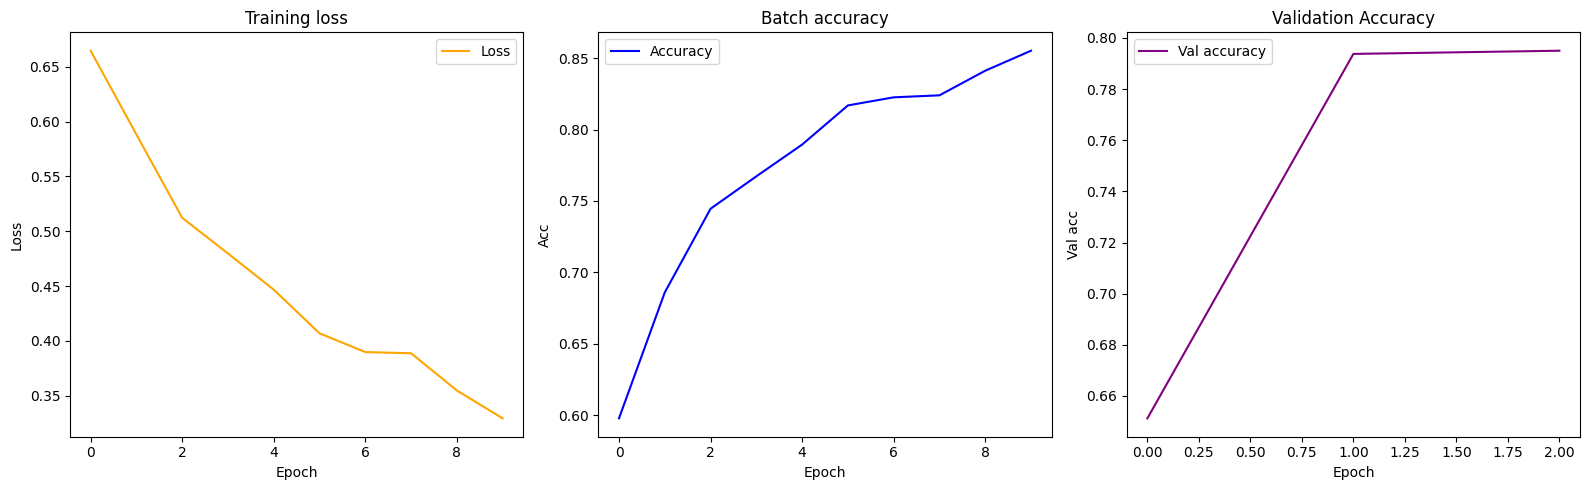

In [13]:
# Hyperparamètres
EPOCHS = 10 #250 # 1000
BATCH_SIZE = 256
LEARNING_RATE = 0.0001
VALIDATION_EPOCH_INTERVAL = 4 
CHECKPOINT_EPOCH_INTERVAL = 200
STARTING_EPOCH = 0

# Early Stopping Configuration
early_stopping_threshold = 0.9  # Seuil de précision (exemple: 90%)
early_stopping_patience = 3    # Nombre de validations consécutives au-dessus du seuil pour arrêter


model = CNNBinaryClassifier(input_shape=(1, 128, 128))
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    model = model.cuda()

#==============================================

def train_model(model, train_loader, criterion, optimizer, epochs, start_epoch = 0):
    warnings.filterwarnings('ignore')
    model.train()
    losses = []
    accuracies = []
    val_accuracies = []

    # Variables de suivi pour le temps
    epoch_times = []

    # Early stopping tracking variables
    best_val_accuracy = 0
    consecutive_val_success = 0  # Compteur de validations réussies
    
    if start_epoch > 0:
        load_nearest_checkpoint(model, start_epoch)

    # Temps de début d'entraînement
    total_start_time = time.time()
        
    for epoch in range(0, epochs):
        epoch_start_time = time.time()  # Début de l'époque
        running_loss = 0.0
        all_preds = []
        all_labels = []

        for images, labels in train_loader:
            images = images.float()
            labels = labels.float().view(-1)

            if train_on_gpu:
                images = images.cuda()
                labels = labels.cuda()

            optimizer.zero_grad()
            outputs = model(images)

            outputs = outputs.view(-1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            all_preds.extend(outputs.detach().cpu().numpy())
            all_labels.extend(labels.detach().cpu().numpy())

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = accuracy_score(np.round(all_preds), np.round(all_labels))
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)

        # Fin de l'époque et calcul du temps écoulé
        epoch_time = time.time() - epoch_start_time
        epoch_times.append(epoch_time)  # Stockage du temps de chaque époque

        if (epoch) % VALIDATION_EPOCH_INTERVAL == 0:
            acc, _ = validate_model(model, val_loader)
            val_accuracies.append(acc)
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.6f}, Accuracy: {epoch_acc * 100:.2f}%, "
                  f"Val accuracy: {acc * 100:.2f}%, Epoch time: {epoch_time:.2f}s")

            # Early stopping condition
            if acc >= early_stopping_threshold:
                consecutive_val_success += 1
                if consecutive_val_success >= early_stopping_patience:
                    print(f"Early stopping triggered after {epoch+1} epochs. Validation accuracy {acc * 100:.2f}% "
                          f"exceeded threshold for {early_stopping_patience} consecutive intervals.")
                    break
            else:
                consecutive_val_success = 0  # Reset if threshold not met
        
        else:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.6f}, Accuracy: {epoch_acc * 100:.3f}%, "
                  f"Epoch time: {epoch_time:.2f}s")
            

        if (epoch) % CHECKPOINT_EPOCH_INTERVAL == 0 and epoch > 0:
            save_checkpoint(model, epoch, directory="./checkpoints")

    # Temps total d'entraînement
    total_training_time = time.time() - total_start_time
    average_epoch_time = sum(epoch_times) / len(epoch_times)
    
    print(f"\nTotal training time: {total_training_time:.2f}s")
    print(f"Average time per epoch: {average_epoch_time:.2f}s")
                
    plot_training_metrics(losses, accuracies, val_accuracies)

train_model(model, train_loader, criterion, optimizer, EPOCHS, start_epoch=STARTING_EPOCH)

## Export

In [14]:
def export(export_path = './models/cat_or_dog.onnx'):
    warnings.filterwarnings('default')
    if not os.path.exists('./models'):
        os.makedirs('./models')
    
    X, y = get_random_samples(train_dataset, 1)
    input_tensor = X[0].unsqueeze(0).to(device)
    
    torch.onnx.export(model,                      # model being run
                      input_tensor,               # model input (or a tuple for multiple inputs)
                      export_path,                # where to save the model (can be a file or file-like object)
                      input_names = ['input'],    # the model's input names
                      output_names = ['output'])  # the model's output names
    warnings.filterwarnings('ignore')

export()

## Re-loading

In [15]:
warnings.filterwarnings('ignore')

In [16]:
import_path = './models/cat_or_dog.onnx'

onnx_model = onnx.load(import_path)
onnx.checker.check_model(onnx_model)

## Testing

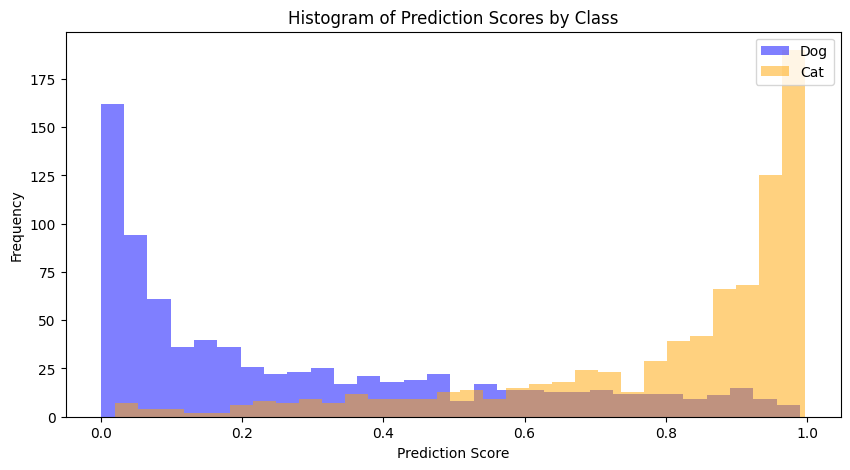

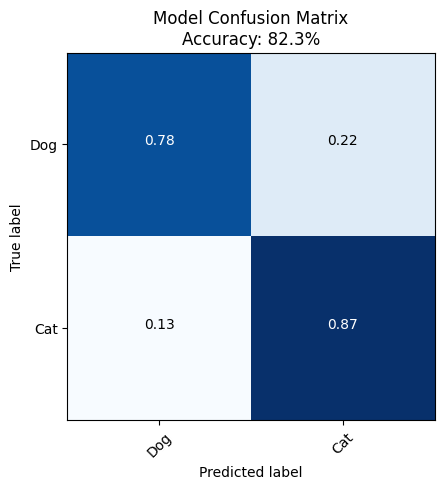

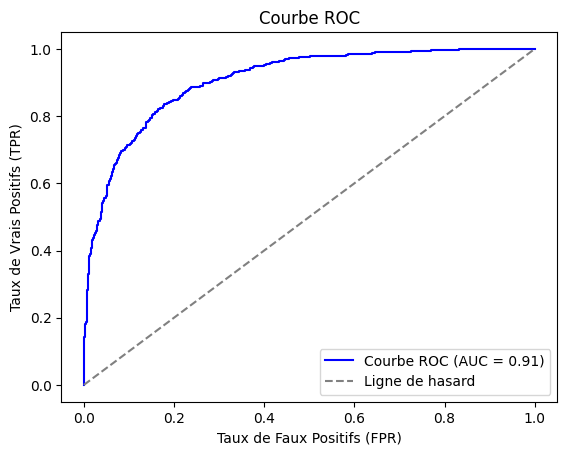

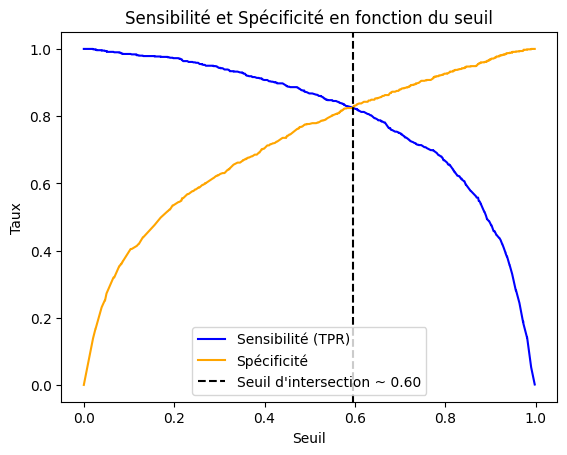

In [17]:
# Store prediction scores and true labels
prediction_scores = []  # To store raw prediction scores (before threshold)
true_labels = []        # To store the true binary labels (0 or 1)

ort_session = ort.InferenceSession(import_path, providers=['CPUExecutionProvider'])
classes = ['Dog', 'Cat']  # 0 -> Dog, 1 -> Cat

# Iterate over the test loader
for images, labels in test_loader:
    for image, label in zip(images, labels):
        # Move the image to the CPU and add a batch dimension
        image = image.unsqueeze(0).cpu()

        # Run inference on the image and get raw score
        outputs = ort_session.run(None, {'input': image.numpy()})
        score = outputs[0][0]  # Probability or raw score for 'Cat' class

        # Store the raw prediction score and the true label
        prediction_scores.append(score)
        true_labels.append(label.cpu().detach().numpy().item())

accuracy = sum((score[0] > 0.5) == label for score, label in zip(prediction_scores, true_labels)) / len(prediction_scores)
cm = confusion_matrix(true_labels, [int(score > 0.5) for score in prediction_scores], labels=[0, 1])


plot_score_distribution(prediction_scores, true_labels, classes, threshold=0.5)
plot_confusion_matrix(cm, classes=classes, title=f"Model Confusion Matrix\nAccuracy: {accuracy * 100:.1f}%", normalize=True)

fpr, tpr, thresholds = plot_roc_curve(true_labels, prediction_scores)

plot_sensitivity_specificity_vs_thresholds(thresholds, tpr, fpr)